In [3]:
# Import libraries
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
import itertools
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults


In [4]:
series = pd.read_csv("C:\\Users\\Anks\\Downloads\\Airlines+Data.csv", header=0, index_col=0, parse_dates=True)
series


,Passengers
Month,
Jan-95,112
Feb-95,118
Mar-95,132
Apr-95,129
May-95,121
...,...
Aug-02,405
Sep-02,355
Oct-02,306


<AxesSubplot:xlabel='Month'>

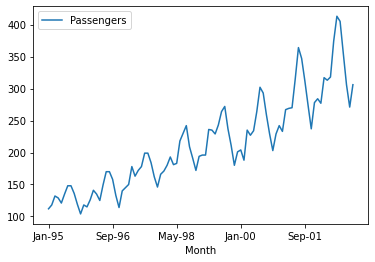

In [5]:
# line plot of time series
#plt.figure(figsize=(24,7))
series.plot()

array([[<AxesSubplot:title={'center':'Passengers'}>]], dtype=object)

<Figure size 1728x504 with 0 Axes>

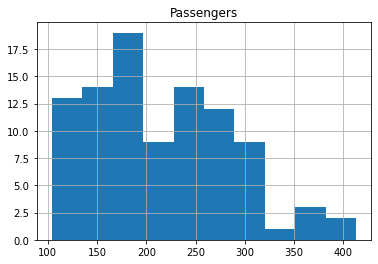

In [6]:
plt.figure(figsize=(24,7))
series.hist()

<AxesSubplot:ylabel='Density'>

<Figure size 1728x504 with 0 Axes>

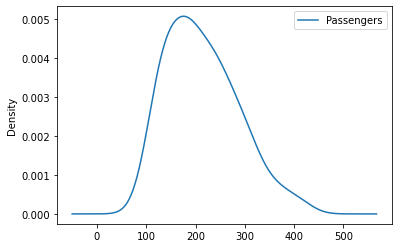

In [7]:
plt.figure(figsize=(24,7))
series.plot(kind='kde')

C:\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


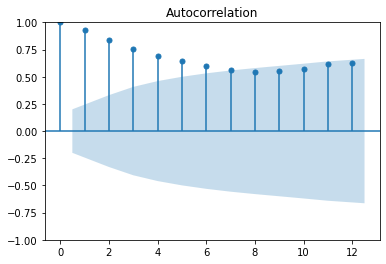

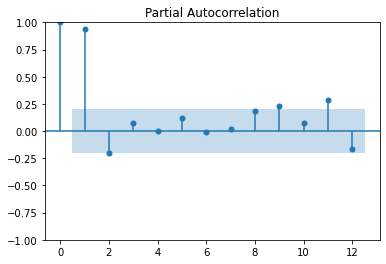

In [8]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(series.Passengers,lags=12)
tsa_plots.plot_pacf(series.Passengers,lags=12)
plt.show()

# Moving Average Method

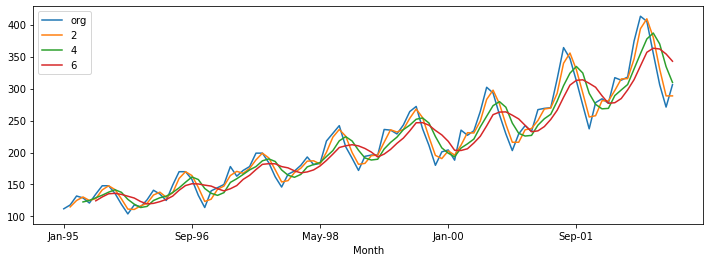

In [15]:
plt.figure(figsize=(12,4))
series.Passengers.plot(label="org")
for i in range(2,8,2):
   series["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

# Time Series Decomposition plot

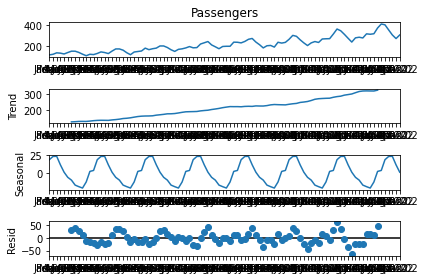

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_ts_add = seasonal_decompose(series.Passengers,period=13)
decompose_ts_add.plot()
plt.show()

In [10]:
# separate out a validation dataset
split_point = len(series) - 10

dataset, validation = series[0:split_point], series[split_point:]

print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

Dataset 86, Validation 10


In [11]:
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

#### Persistence/ Base model

In [12]:
# evaluate a persistence model
# load data
train = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
train

C:\Users\Anks\AppData\Local\Temp\ipykernel_10308\2746187420.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  train = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)


0
Jan-95    112
Feb-95    118
Mar-95    132
Apr-95    129
May-95    121
         ... 
Oct-01    274
Nov-01    237
Dec-01    278
Jan-02    284
Feb-02    277
Name: 1, Length: 86, dtype: int64

In [13]:
# prepare data
X = train.values
X

array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
       126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150,
       178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193,
       181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235,
       229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234,
       264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315,
       364, 347, 312, 274, 237, 278, 284, 277], dtype=int64)

In [14]:
X = X.astype('float32')
X

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277.],
      dtype=float32)

In [15]:
train_size = int(len(X) * 0.50)
train_size

43

In [16]:
train, test = X[0:train_size], X[train_size:]

In [17]:
train

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230.],
      dtype=float32)

In [18]:
test

array([242., 209., 191., 172., 194., 196., 196., 236., 235., 229., 243.,
       264., 272., 237., 211., 180., 201., 204., 188., 235., 227., 234.,
       264., 302., 293., 259., 229., 203., 229., 242., 233., 267., 269.,
       270., 315., 364., 347., 312., 274., 237., 278., 284., 277.],
      dtype=float32)

In [19]:
# walk-forward validation
history = [x for x in train]
history

[112.0,
 118.0,
 132.0,
 129.0,
 121.0,
 135.0,
 148.0,
 148.0,
 136.0,
 119.0,
 104.0,
 118.0,
 115.0,
 126.0,
 141.0,
 135.0,
 125.0,
 149.0,
 170.0,
 170.0,
 158.0,
 133.0,
 114.0,
 140.0,
 145.0,
 150.0,
 178.0,
 163.0,
 172.0,
 178.0,
 199.0,
 199.0,
 184.0,
 162.0,
 146.0,
 166.0,
 171.0,
 180.0,
 193.0,
 181.0,
 183.0,
 218.0,
 230.0]

In [20]:
predictions = list()

for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    
    # observation
    obs = test[i]
    history.append(obs)
    
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

>Predicted=230.000, Expected=242.000
>Predicted=242.000, Expected=209.000
>Predicted=209.000, Expected=191.000
>Predicted=191.000, Expected=172.000
>Predicted=172.000, Expected=194.000
>Predicted=194.000, Expected=196.000
>Predicted=196.000, Expected=196.000
>Predicted=196.000, Expected=236.000
>Predicted=236.000, Expected=235.000
>Predicted=235.000, Expected=229.000
>Predicted=229.000, Expected=243.000
>Predicted=243.000, Expected=264.000
>Predicted=264.000, Expected=272.000
>Predicted=272.000, Expected=237.000
>Predicted=237.000, Expected=211.000
>Predicted=211.000, Expected=180.000
>Predicted=180.000, Expected=201.000
>Predicted=201.000, Expected=204.000
>Predicted=204.000, Expected=188.000
>Predicted=188.000, Expected=235.000
>Predicted=235.000, Expected=227.000
>Predicted=227.000, Expected=234.000
>Predicted=234.000, Expected=264.000
>Predicted=264.000, Expected=302.000
>Predicted=302.000, Expected=293.000
>Predicted=293.000, Expected=259.000
>Predicted=259.000, Expected=229.000
>

In [21]:
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 25.698


#### ARIMA Hyperparameters

In [22]:
# grid search ARIMA parameters for a time series
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # make predictions
    predictions = list()
    for i in range(len(test)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[i])
    
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

#### Grid search for p,d,q values

In [23]:
# evaluate combinations of p, d and q values for an ARIMA model

def evaluate_models(dataset, p_values, d_values, q_values):
    
    dataset = dataset.astype('float32')
    
    best_score, best_cfg = float('inf'), None
    
    for p,d,q in itertools.product(p_values, d_values, q_values):
    #for p in p_values:
    #    for d in d_values:
    #        for q in q_values:
    
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA %s RMSE=%.3f' % (best_cfg, best_score))

In [24]:
'''
import itertools

L1 = [1,2,3,4,5]
L2 = ['A','B','C']
L3 = [9,8,7]

for x,y,z in itertools.product(L1,L2,L3):
    print(x,y,z)
'''

"\nimport itertools\n\nL1 = [1,2,3,4,5]\nL2 = ['A','B','C']\nL3 = [9,8,7]\n\nfor x,y,z in itertools.product(L1,L2,L3):\n    print(x,y,z)\n"

In [25]:
# load dataset
train = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
train

C:\Users\Anks\AppData\Local\Temp\ipykernel_10308\240493752.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  train = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)


0
Jan-95    112
Feb-95    118
Mar-95    132
Apr-95    129
May-95    121
         ... 
Oct-01    274
Nov-01    237
Dec-01    278
Jan-02    284
Feb-02    277
Name: 1, Length: 86, dtype: int64

In [26]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)

In [ ]:
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=78.563
ARIMA(0, 0, 1) RMSE=44.789
ARIMA(0, 0, 2) RMSE=34.690
ARIMA(0, 0, 3) RMSE=28.878
ARIMA(0, 0, 4) RMSE=29.750
ARIMA(0, 1, 0) RMSE=25.698
ARIMA(0, 1, 1) RMSE=25.127
ARIMA(0, 1, 2) RMSE=25.788
ARIMA(0, 1, 3) RMSE=25.747
ARIMA(0, 1, 4) RMSE=24.214
ARIMA(0, 2, 0) RMSE=32.218
ARIMA(0, 2, 1) RMSE=25.904
ARIMA(0, 2, 2) RMSE=25.335
ARIMA(0, 2, 3) RMSE=26.766
ARIMA(0, 2, 4) RMSE=24.184
ARIMA(0, 3, 0) RMSE=51.228
ARIMA(0, 3, 1) RMSE=32.475
ARIMA(0, 3, 2) RMSE=26.424
ARIMA(0, 3, 3) RMSE=25.815
ARIMA(0, 3, 4) RMSE=26.528
ARIMA(0, 4, 0) RMSE=90.046
ARIMA(0, 4, 1) RMSE=51.652
ARIMA(0, 4, 2) RMSE=33.059
ARIMA(0, 4, 3) RMSE=27.614
ARIMA(0, 4, 4) RMSE=31.414
ARIMA(1, 0, 0) RMSE=26.037
ARIMA(1, 0, 1) RMSE=25.286
ARIMA(1, 0, 2) RMSE=25.816
ARIMA(1, 0, 3) RMSE=27.775
ARIMA(1, 0, 4) RMSE=25.269
ARIMA(1, 1, 0) RMSE=25.440
ARIMA(1, 1, 1) RMSE=25.142
ARIMA(1, 1, 2) RMSE=24.226
ARIMA(1, 1, 3) RMSE=24.565
ARIMA(1, 1, 4) RMSE=24.278
ARIMA(1, 2, 0) RMSE=31.354
ARIMA(1, 2, 1) RMSE=25.673
A

#### Build Model based on the optimized values

In [3]:
import pandas as pd

In [4]:
# save finalized model to file
# load data
train = pd.read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
train

,112
Jan-95,
Feb-95,118
Mar-95,132
Apr-95,129
May-95,121
Jun-95,135
...,...
Oct-01,274
Nov-01,237
Dec-01,278


In [5]:
# prepare data
X = train.values
X = X.astype('float32')

In [6]:
# fit model
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit()
forecast = model_fit.forecast(steps = 10)
forecast

array([273.97340317, 274.68726304, 275.50494009, 275.56025427,
       275.40180883, 275.35027031, 275.37069932, 275.38670536,
       275.38642737, 275.38298332])

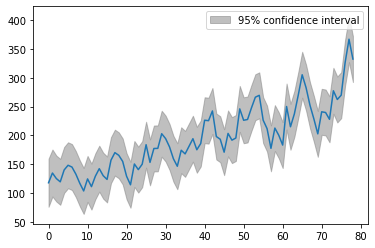

In [7]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(model_fit,1,79)
#model_fit.plot_predict(1, 79)
plt.show()

In [8]:
#Error on the test data
val = pd.read_csv('validation.csv', header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

76.67615269250932

#### Combine train and test data and build final model

In [9]:
# fit model
data = pd.read_csv("C:\\Users\\Anks\\Downloads\\Airlines+Data.csv", header=0, index_col=0, parse_dates=True)

# prepare data
X = train.values
X = X.astype('float32')

In [10]:
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit()

In [11]:
forecast=model_fit.forecast(steps=10)
forecast

array([273.97340317, 274.68726304, 275.50494009, 275.56025427,
       275.40180883, 275.35027031, 275.37069932, 275.38670536,
       275.38642737, 275.38298332])

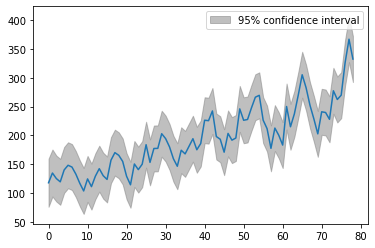

In [12]:
#model_fit.plot_predict(1,90)
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(model_fit,1,79)
plt.show()